In [36]:
import torch
import torch.optim as optim
import torch.nn as nn
import os

from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,  Dataset
import torch.nn.functional as F
import warnings

import torchvision

import tqdm
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor,Normalize
import torchvision.transforms as transforms

import numpy as np
from Amin_utility_Q4 import model_train

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Loader

In [37]:
def Data_loader(colored=False):

  class ColoredMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return self.to_rgb(image), label

    def to_rgb(self,image):
        image_rgb = torch.zeros((3, 28, 28), dtype=torch.float32)
        for j in range(3):
            random_factor = np.random.rand()
            image_rgb[j] = image * random_factor
        return image_rgb

  transform = Compose([ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))])

  train_dataset = MNIST('./data/', train=True, download=True, transform=transform)
  test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

  if colored:
      train_dataset = ColoredMNIST(train_dataset)
      test_dataset = ColoredMNIST(test_dataset)

  # Define the size of the training and validation sets
  train_size = int(0.8 * len(train_dataset))    # 80% for training
  valid_size = len(train_dataset) - train_size  # 20% for validation

  # Split the dataset
  train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])



  train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
  val_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

  print("Train Size: ",len(train_loader.dataset))
  print("Valid Size: ",len(valid_dataset))
  print("Test Size: ",len(test_dataset))

  batch = next(iter(test_loader))
  datas,_= batch



  fig, axes = plt.subplots(2, 5, figsize=(10, 5))
  for i, ax in enumerate(axes.flat):
      image = datas[i].detach().cpu().numpy()
      image = np.clip(image, 0, 1)
      ax.imshow(np.transpose(image, (1, 2, 0)))
      ax.axis('off')
  if colored:
      plt.suptitle('Sample Images {colored Dataset}')
  else:
      plt.suptitle('Sample Images')

  plt.show()

  return train_loader, val_loader, test_loader


# Advantages of VAE-VQ over Standard VAE

Variational Autoencoder with Vector Quantization (VAE-VQ) offers several advantages over a standard Variational Autoencoder (VAE).

## 1. Discrete Latent Representations:
   - VAE-VQ introduces a discrete latent space through vector quantization, where latent variables are mapped to a finite set of discrete codes.
   - In contrast, standard VAEs typically have continuous latent spaces.

## 2. Improved Data Representation:
   - The discrete nature of VAE-VQ's latent space allows for more interpretable and structured representations of data.
   - VQ helps capture distinct and meaningful features in the data by assigning discrete codes to different clusters or categories.

## 3. Enhanced Sample Generation:
   - The discrete latent space enables better control over the generation process.
   - Sample generation in VAE-VQ tends to be more structured and controllable due to the discrete nature of the latent codes.

## 4. Addressing Mode Collapse:
   - VAE-VQ can mitigate mode collapse issues often encountered in standard VAEs, where the generator produces limited diversity in generated samples.
   - The discrete latent space encourages diversity in the generated samples, reducing the likelihood of mode collapse.



# Vector Quantized Variational Autoencoders

## Architecture

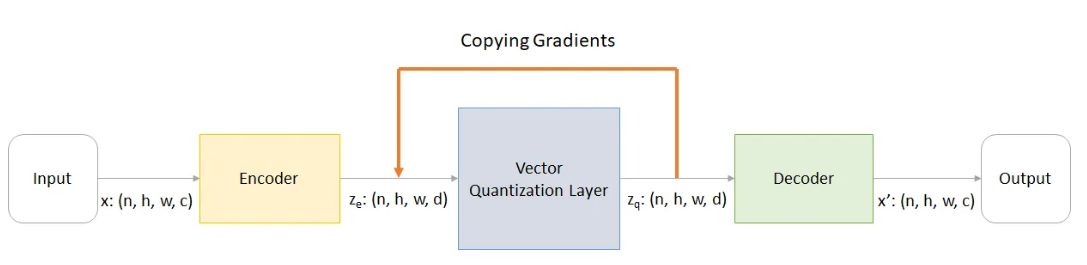

## Encoder

In [38]:
class Residual_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Residual_block, self).__init__()
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv1 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)

        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.relu1(x)
        out = self.conv3(out)
        out = self.relu2(out)
        out = self.conv1(out)

        return out + residual


In [39]:
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(Encoder, self).__init__()

        self.conv4_1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=4, stride=2, padding=1)
        self.conv4_2 = nn.Conv2d(hidden_channels, hidden_channels * 2, kernel_size=4, stride=2, padding=1)

        # Residual blocks with 256 hidden units
        self.residual_block1 = Residual_block(hidden_channels * 2, 256)
        self.residual_block2 = Residual_block(256, 256)

        self.relu1 = nn.ReLU(inplace=True)
        #self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        #print(x.shape)

        x = self.conv4_1(x)
        #print(x.shape)
        x = self.relu1(x)
        x = self.conv4_2(x)
        x = self.residual_block1(x)
        x = self.residual_block2(x)
        return x


## Decoder

In [40]:
class Decoder(nn.Module):
  def __init__(self,hidden_channels,out_channels):
    super(Decoder,self).__init__()
    self.residual_block1 = Residual_block(256, 256)
    self.residual_block2 = Residual_block(256, 256)

    self.transconv1 = nn.ConvTranspose2d(256, hidden_channels * 2, kernel_size=4, stride=2, padding=1)
    self.transconv2 = nn.ConvTranspose2d(hidden_channels * 2, out_channels , kernel_size=4, stride=2, padding=1)

  def forward(self,x):
    x = self.residual_block1(x)
    x = self.residual_block2(x)
    x = self.transconv1(x)
    x = self.transconv2(x)

    return x

## Vector Quantization

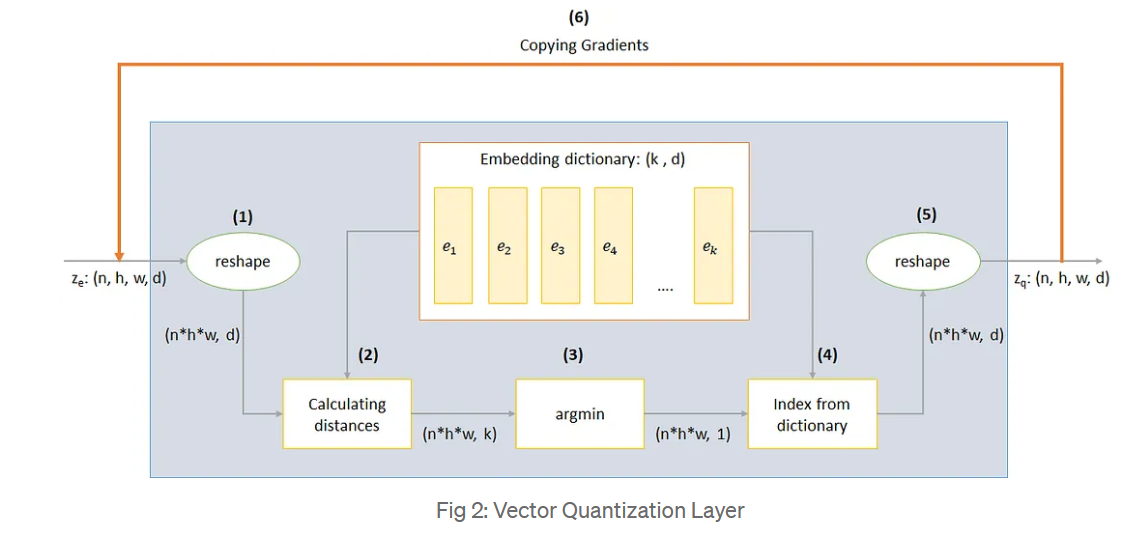

$$
L = \log\left(p(x | zq(x))\right) + {\|ze(x) \cdot \text{detach}() - e\|^2} + \beta {\|ze(x) - e \cdot \text{detach}()\|^2}
$$

$$
\begin{align*}
\text{Codebook Loss:} & \quad \|ze(x) \cdot \text{detach}() - e\|^2 \\
\text{Commitment Loss:} & \quad \beta \|ze(x) - e \cdot \text{detach}()\|^2
\end{align*}
$$



In [41]:
class VectorQuantization(nn.Module):
    def __init__(self, codebook_dim, codebook_size, beta):
        super(VectorQuantization, self).__init__()

        self.codebook_size = codebook_size
        self.codebook_dim = codebook_dim
        self.embedding = nn.Embedding(self.codebook_size, codebook_dim)
        self.embedding.weight.data.uniform_(-1/self.codebook_size, 1/self.codebook_size)
        self.beta = beta

    def forward(self, x):
        # BCHW -> BHWC
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1).contiguous()

        x_flat = x.view(-1, self.codebook_dim)

        # Compute distances
        codebook_squares = torch.sum(self.embedding.weight ** 2, dim=1)
        input_squares = torch.sum(x_flat ** 2, dim=1, keepdim=True)
        dist = input_squares + codebook_squares - 2 * torch.matmul(x_flat, self.embedding.weight.t())

        # Find the index of the nearest neighbor in the codebook
        min_encoding_indices = torch.argmin(dist, dim=-1)

        # Quantize the input based on the nearest neighbor
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))
        x = x.view((-1, C))
        quant_out = quant_out.view((-1, C))

        # Compute quantization loss
        codebook_loss = F.mse_loss(quant_out , x.detach())
        commmitment_loss = F.mse_loss(quant_out.detach() , x)

        quantize_loss = self.beta * commmitment_loss + codebook_loss

        quant_out = x + (quant_out - x).detach()

        # Reshape back to BHWC
        quant_out = quant_out.view((B, H, W, C)).permute(0, 3, 1, 2)

        return quant_out, quantize_loss

## VQ_VAE

In [42]:
class VQVAE(nn.Module):
  def __init__(self,codebook_size,codebook_dim,in_channels=1,out_channels=1):
    super(VQVAE,self).__init__()
    self.encoder=Encoder(in_channels=in_channels, hidden_channels=128)
    self.decoder=Decoder(hidden_channels=128,out_channels=out_channels)
    self.vq_layer = VectorQuantization(codebook_dim, codebook_size, beta=0.25)


  def forward(self,x):
    z = self.encoder(x)
    z, vq_loss = self.vq_layer(z)
    x_recon = self.decoder(z)

    return x_recon, vq_loss


# Train the model

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Train Size:  48000
Valid Size:  12000
Test Size:  10000


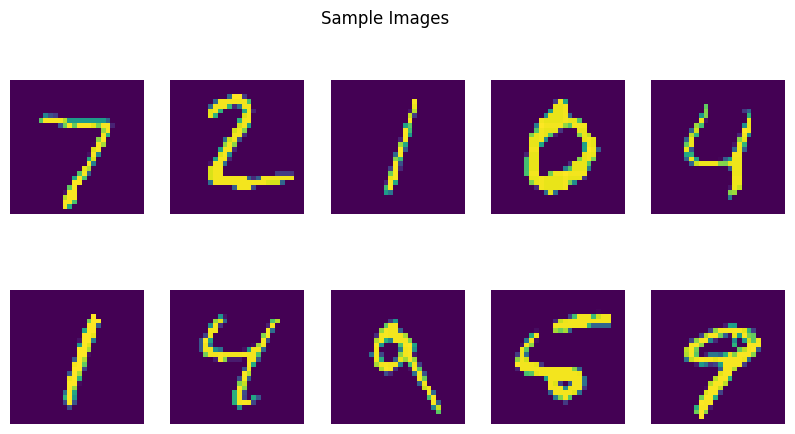

In [44]:
model=VQVAE(codebook_size=3,codebook_dim=2,in_channels=1,out_channels=1).to(device)

optimizer= optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

train_loader, val_loader, test_loader = Data_loader(colored=False)

100%|██████████| 375/375 [00:25<00:00, 14.51it/s]


Epoch 1/5, Train Loss: 0.4731, Validation Loss: 0.1307
Saved best model


100%|██████████| 375/375 [00:26<00:00, 14.35it/s]


Epoch 2/5, Train Loss: 0.0967, Validation Loss: 0.0801
Saved best model


100%|██████████| 375/375 [00:26<00:00, 14.39it/s]


Epoch 3/5, Train Loss: 0.0762, Validation Loss: 0.0756
Saved best model


100%|██████████| 375/375 [00:26<00:00, 14.33it/s]


Epoch 4/5, Train Loss: 0.0765, Validation Loss: 0.0764


100%|██████████| 375/375 [00:26<00:00, 14.30it/s]


Epoch 5/5, Train Loss: 0.0754, Validation Loss: 0.0756
Saved best model


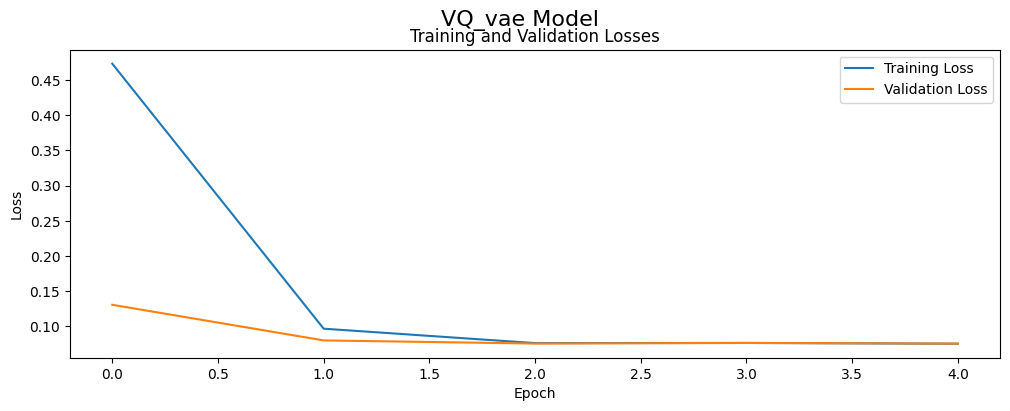

In [45]:
my = model_train(model=model, Name = 'VQ_vae', train_loader=train_loader, test_loader=test_loader, val_loader=val_loader,
                 optimizer=optimizer, criterion=criterion, num_epochs=5, device=device)
my.train()


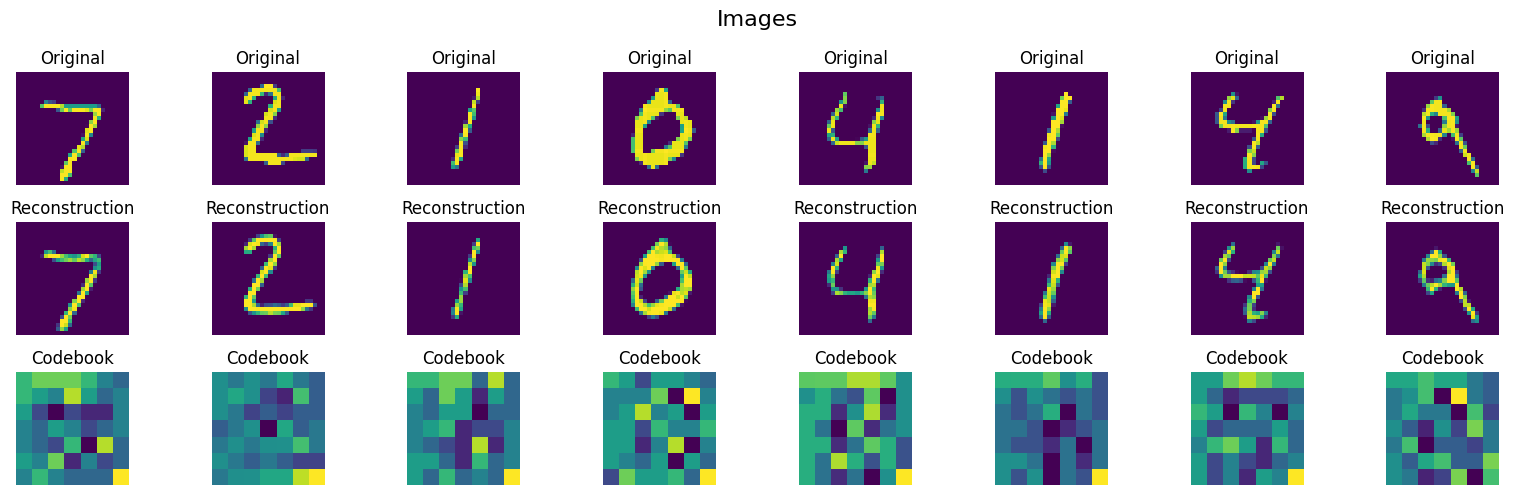


 To display the codeBook output, set num_channel to 1, along with the meanings for all 256 channels 



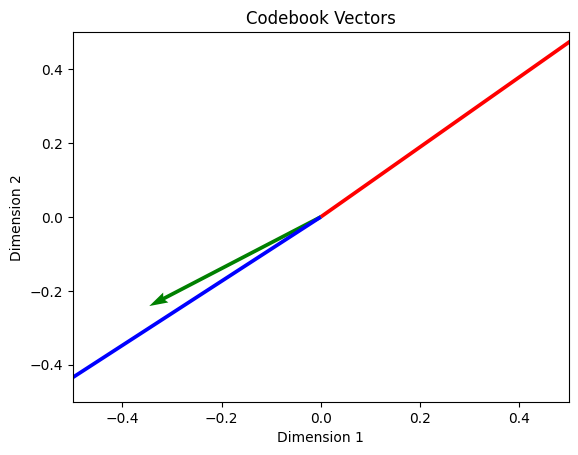

In [46]:
my.Show_test_Image()
my.make_gif()

# Colored Dataset

Train Size:  48000
Valid Size:  12000
Test Size:  10000


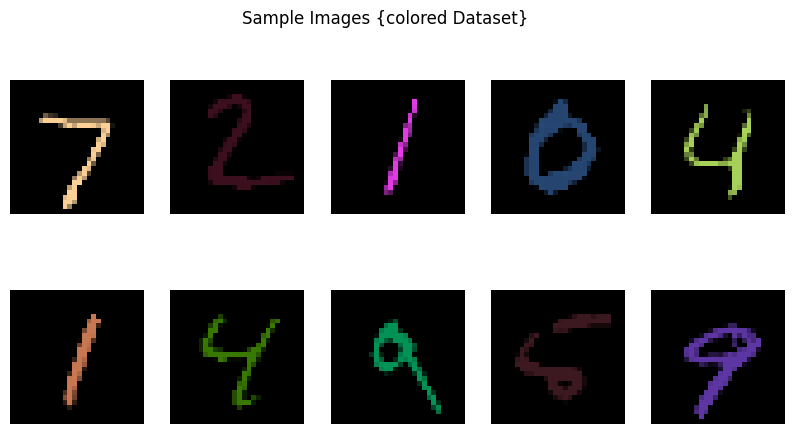

In [47]:
train_loader, val_loader, test_loader = Data_loader(colored=True)


## Variant vectors Size

################################################################################################################################################################

 Train with Codebook Size 4 



100%|██████████| 375/375 [00:30<00:00, 12.25it/s]


Epoch 1/5, Train Loss: 0.1012, Validation Loss: 0.0498
Saved best model


100%|██████████| 375/375 [00:30<00:00, 12.15it/s]


Epoch 2/5, Train Loss: 0.0351, Validation Loss: 0.0291
Saved best model


100%|██████████| 375/375 [00:30<00:00, 12.28it/s]


Epoch 3/5, Train Loss: 0.0256, Validation Loss: 0.0224
Saved best model


100%|██████████| 375/375 [00:30<00:00, 12.24it/s]


Epoch 4/5, Train Loss: 0.0218, Validation Loss: 0.0204
Saved best model


100%|██████████| 375/375 [00:30<00:00, 12.30it/s]


Epoch 5/5, Train Loss: 0.0199, Validation Loss: 0.0194
Saved best model


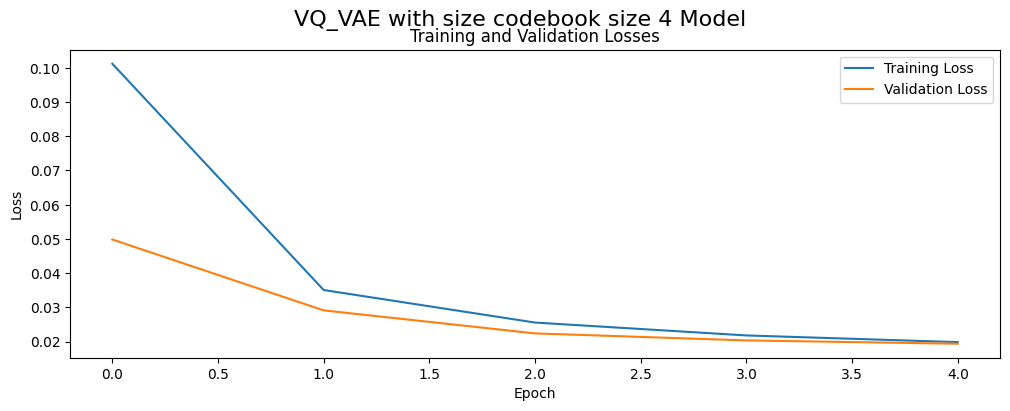

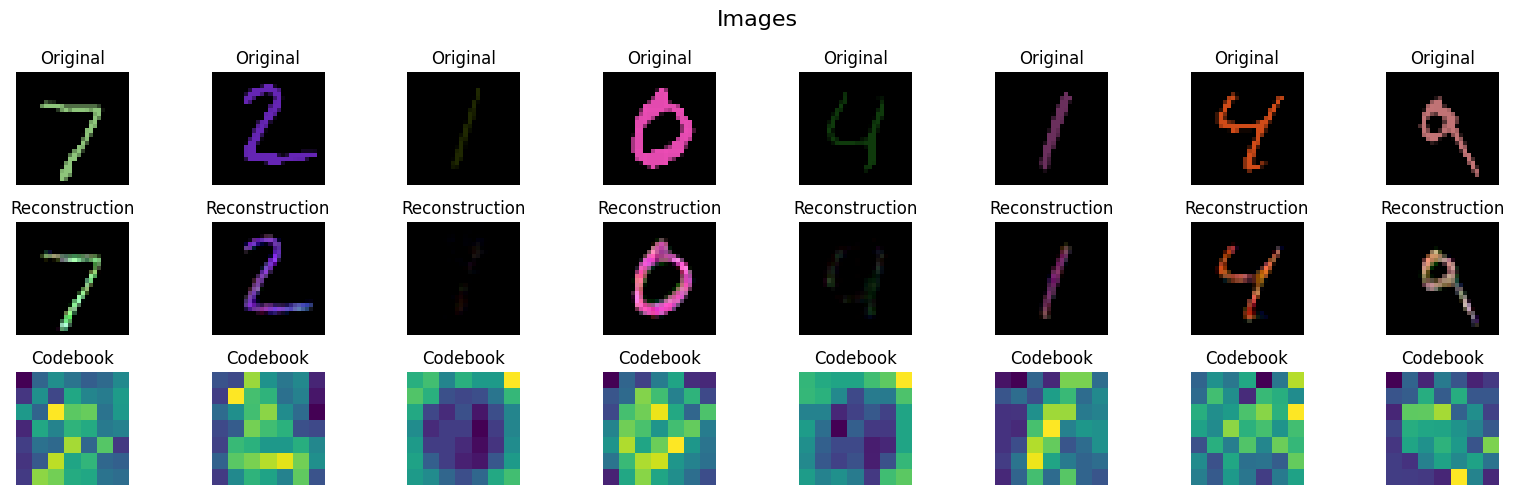


 To display the codeBook output, set num_channel to 1, along with the meanings for all 256 channels 



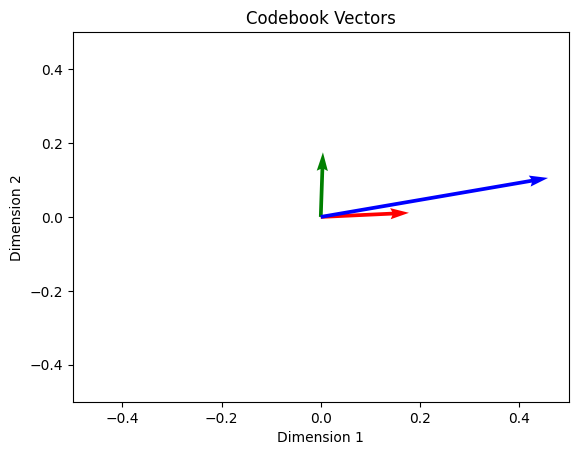

################################################################################################################################################################

 Train with Codebook Size 8 



100%|██████████| 375/375 [00:30<00:00, 12.20it/s]


Epoch 1/5, Train Loss: 0.1285, Validation Loss: 0.0219
Saved best model


100%|██████████| 375/375 [00:30<00:00, 12.21it/s]


Epoch 2/5, Train Loss: 0.0166, Validation Loss: 0.0126
Saved best model


100%|██████████| 375/375 [00:30<00:00, 12.20it/s]


Epoch 3/5, Train Loss: 0.0101, Validation Loss: 0.0090
Saved best model


100%|██████████| 375/375 [00:30<00:00, 12.13it/s]


Epoch 4/5, Train Loss: 0.0076, Validation Loss: 0.0068
Saved best model


100%|██████████| 375/375 [00:31<00:00, 11.88it/s]


Epoch 5/5, Train Loss: 0.0064, Validation Loss: 0.0060
Saved best model


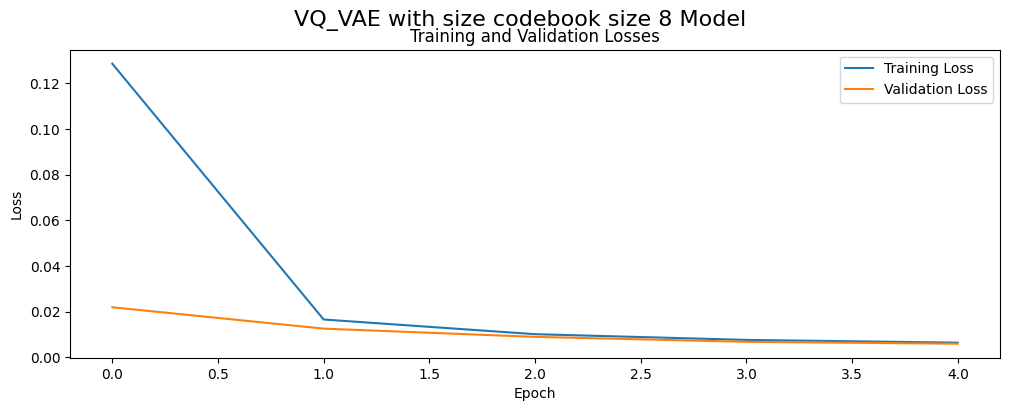

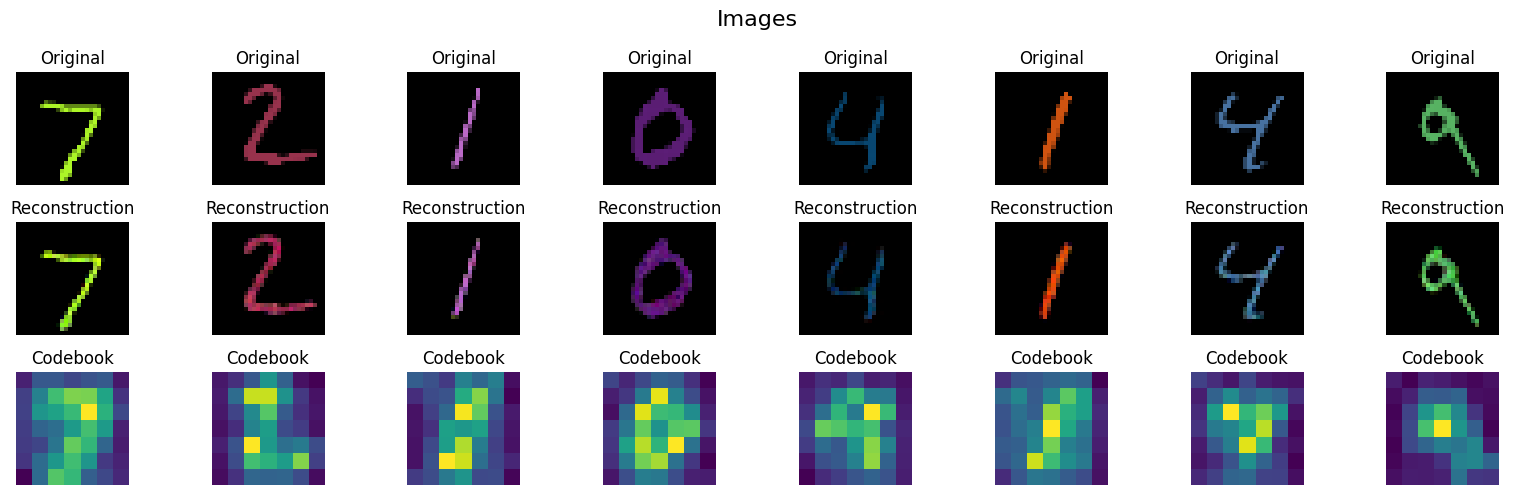


 To display the codeBook output, set num_channel to 1, along with the meanings for all 256 channels 



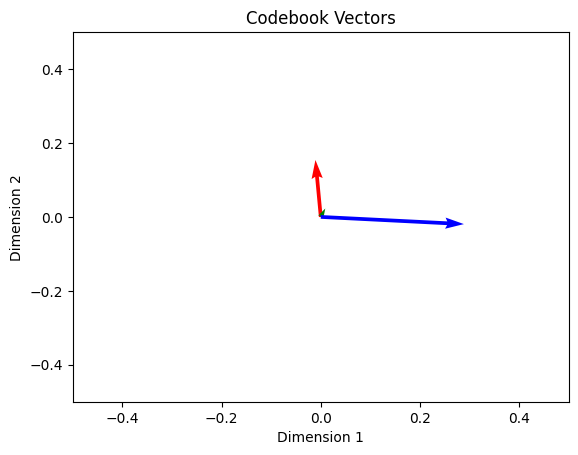

################################################################################################################################################################

 Train with Codebook Size 16 



100%|██████████| 375/375 [00:31<00:00, 11.73it/s]


Epoch 1/5, Train Loss: 0.1388, Validation Loss: 0.0163
Saved best model


100%|██████████| 375/375 [00:31<00:00, 11.77it/s]


Epoch 2/5, Train Loss: 0.0123, Validation Loss: 0.0094
Saved best model


100%|██████████| 375/375 [00:32<00:00, 11.64it/s]


Epoch 3/5, Train Loss: 0.0081, Validation Loss: 0.0071
Saved best model


100%|██████████| 375/375 [00:32<00:00, 11.68it/s]


Epoch 4/5, Train Loss: 0.0062, Validation Loss: 0.0053
Saved best model


100%|██████████| 375/375 [00:32<00:00, 11.65it/s]


Epoch 5/5, Train Loss: 0.0050, Validation Loss: 0.0048
Saved best model


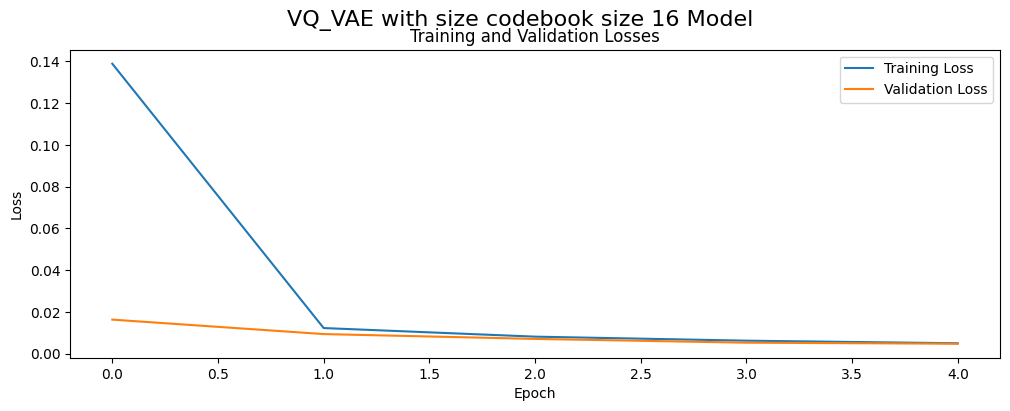

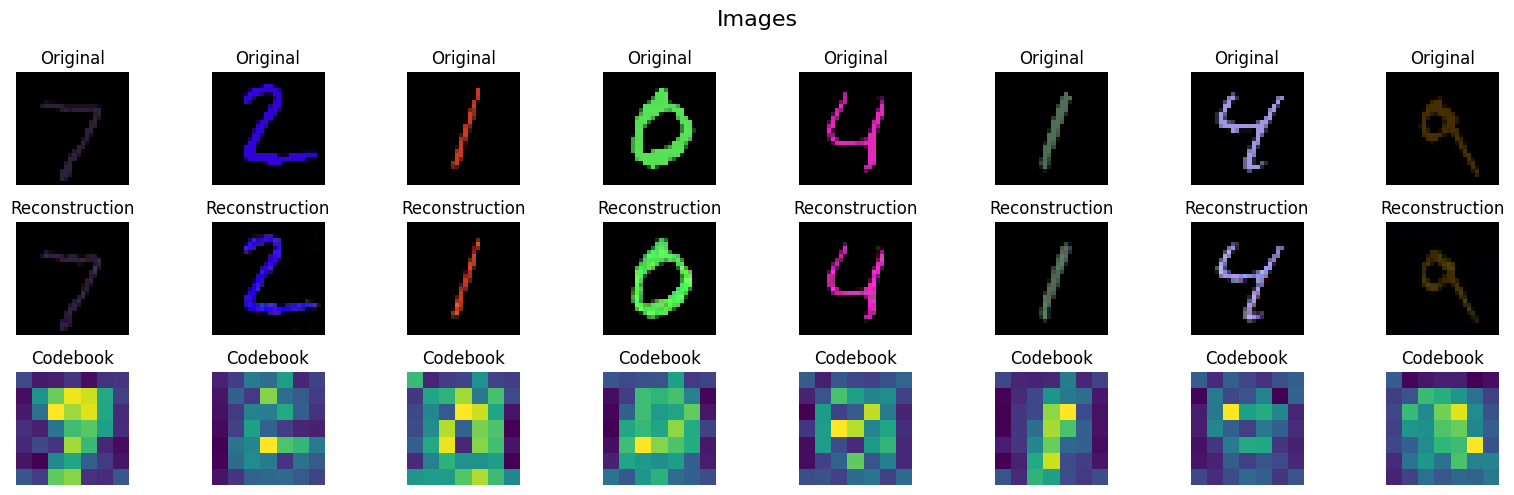


 To display the codeBook output, set num_channel to 1, along with the meanings for all 256 channels 



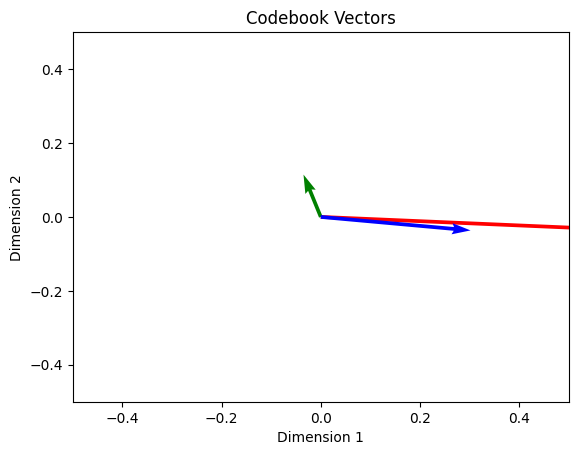

################################################################################################################################################################

 Train with Codebook Size 32 



100%|██████████| 375/375 [00:33<00:00, 11.33it/s]


Epoch 1/5, Train Loss: 0.2118, Validation Loss: 0.0122
Saved best model


100%|██████████| 375/375 [00:32<00:00, 11.50it/s]


Epoch 2/5, Train Loss: 0.0088, Validation Loss: 0.0068
Saved best model


100%|██████████| 375/375 [00:32<00:00, 11.70it/s]


Epoch 3/5, Train Loss: 0.0059, Validation Loss: 0.0053
Saved best model


100%|██████████| 375/375 [00:32<00:00, 11.65it/s]


Epoch 4/5, Train Loss: 0.0046, Validation Loss: 0.0039
Saved best model


100%|██████████| 375/375 [00:32<00:00, 11.71it/s]


Epoch 5/5, Train Loss: 0.0036, Validation Loss: 0.0032
Saved best model


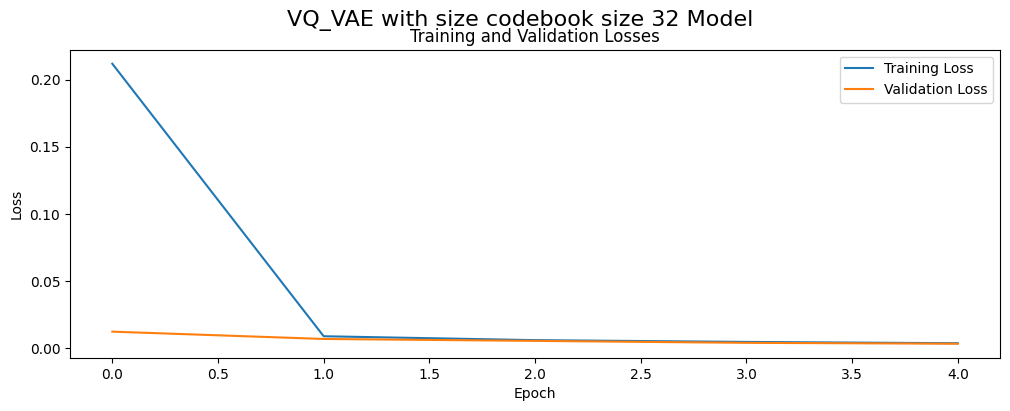

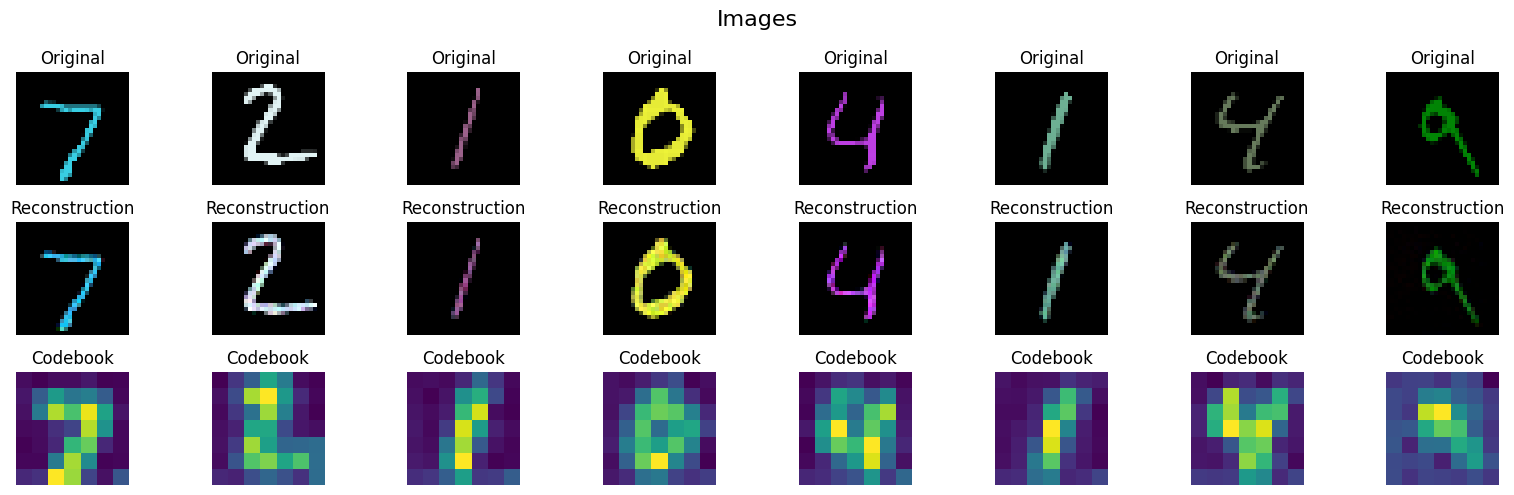


 To display the codeBook output, set num_channel to 1, along with the meanings for all 256 channels 



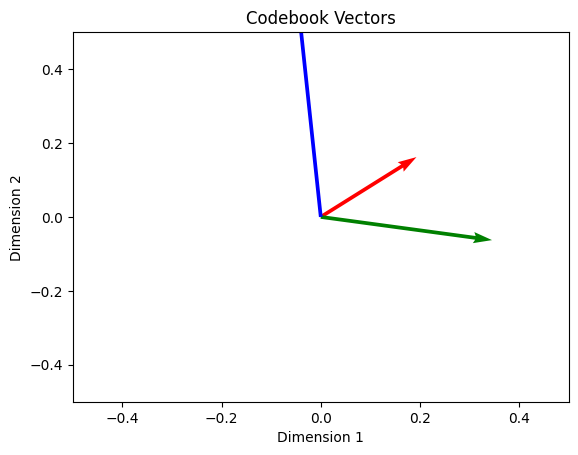

In [48]:
size_codebook = [4,8,16,32]


for i in size_codebook:
    print(40*'####')
    print(f"\n Train with Codebook Size {i} \n")
    model=VQVAE(codebook_size=i,codebook_dim=2,in_channels=3,out_channels=3).to(device)
    optimizer= optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    my = model_train(model=model, Name = f'VQ_VAE with size codebook size {i}', train_loader=train_loader, test_loader=test_loader, val_loader=val_loader,
                 optimizer=optimizer, criterion=criterion, num_epochs=5, device=device)
    my.train()
    my.Show_test_Image()







## variant vectors dimension

################################################################################################################################################################
 
 Train with Codebook dimension 4



100%|██████████| 375/375 [00:30<00:00, 12.44it/s]


Epoch 1/5, Train Loss: 0.2479, Validation Loss: 0.0489
Saved best model


100%|██████████| 375/375 [00:29<00:00, 12.58it/s]


Epoch 2/5, Train Loss: 0.0370, Validation Loss: 0.0302
Saved best model


100%|██████████| 375/375 [00:29<00:00, 12.58it/s]


Epoch 3/5, Train Loss: 0.0264, Validation Loss: 0.0245
Saved best model


100%|██████████| 375/375 [00:30<00:00, 12.31it/s]


Epoch 4/5, Train Loss: 0.0223, Validation Loss: 0.0218
Saved best model


100%|██████████| 375/375 [00:30<00:00, 12.32it/s]


Epoch 5/5, Train Loss: 0.0205, Validation Loss: 0.0188
Saved best model


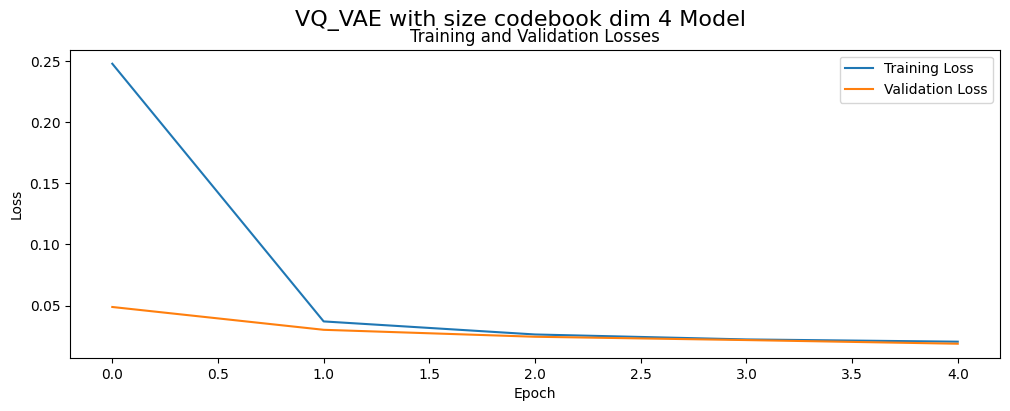

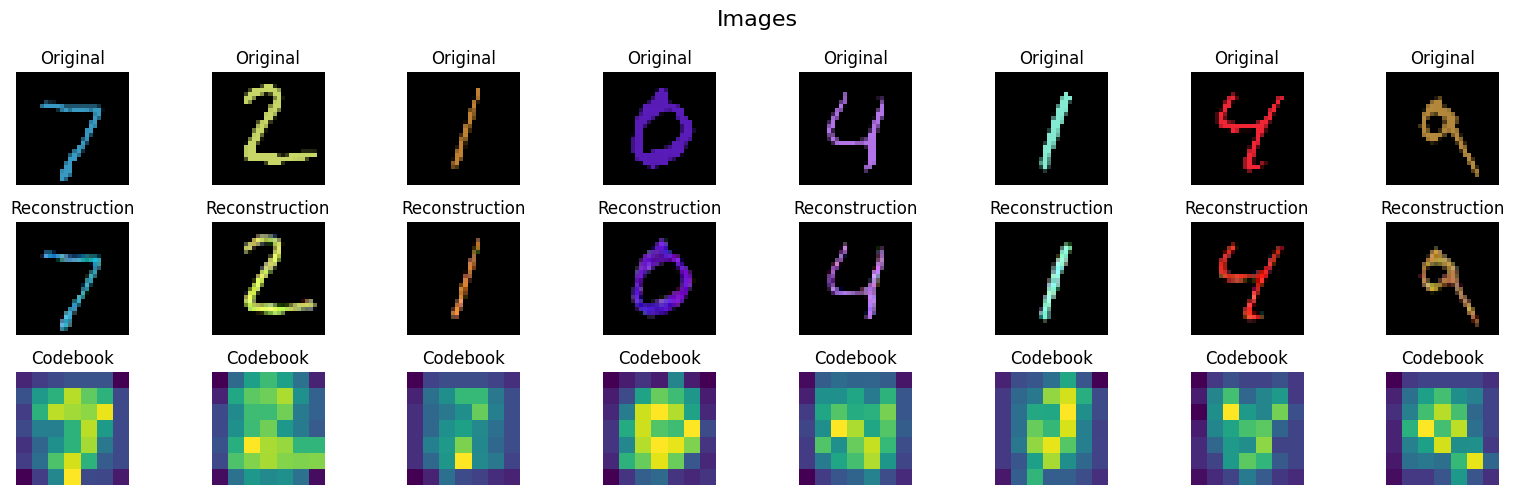


 To display the codeBook output, set num_channel to 1, along with the meanings for all 256 channels 

################################################################################################################################################################
 
 Train with Codebook dimension 8



100%|██████████| 375/375 [00:30<00:00, 12.32it/s]


Epoch 1/5, Train Loss: 0.2317, Validation Loss: 0.0899
Saved best model


100%|██████████| 375/375 [00:29<00:00, 12.56it/s]


Epoch 2/5, Train Loss: 0.0653, Validation Loss: 0.0617
Saved best model


100%|██████████| 375/375 [00:29<00:00, 12.64it/s]


Epoch 3/5, Train Loss: 0.0628, Validation Loss: 0.0684


100%|██████████| 375/375 [00:29<00:00, 12.54it/s]


Epoch 4/5, Train Loss: 0.0745, Validation Loss: 0.0787


100%|██████████| 375/375 [00:29<00:00, 12.58it/s]


Epoch 5/5, Train Loss: 0.0779, Validation Loss: 0.0740


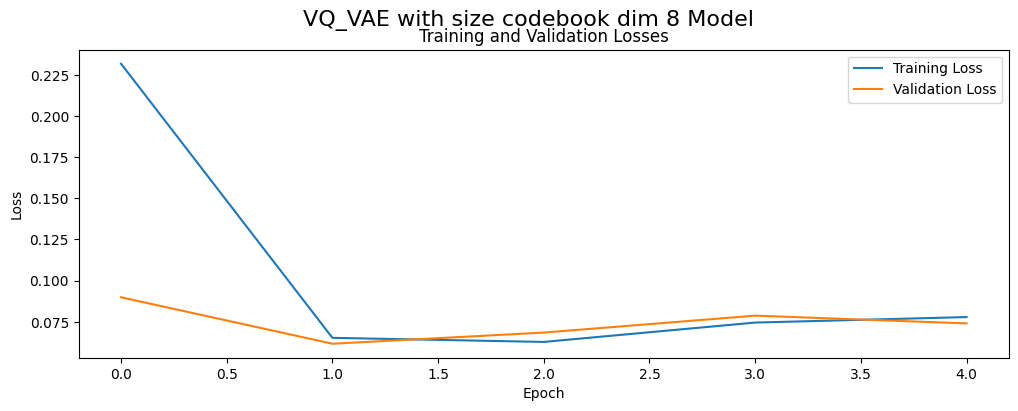

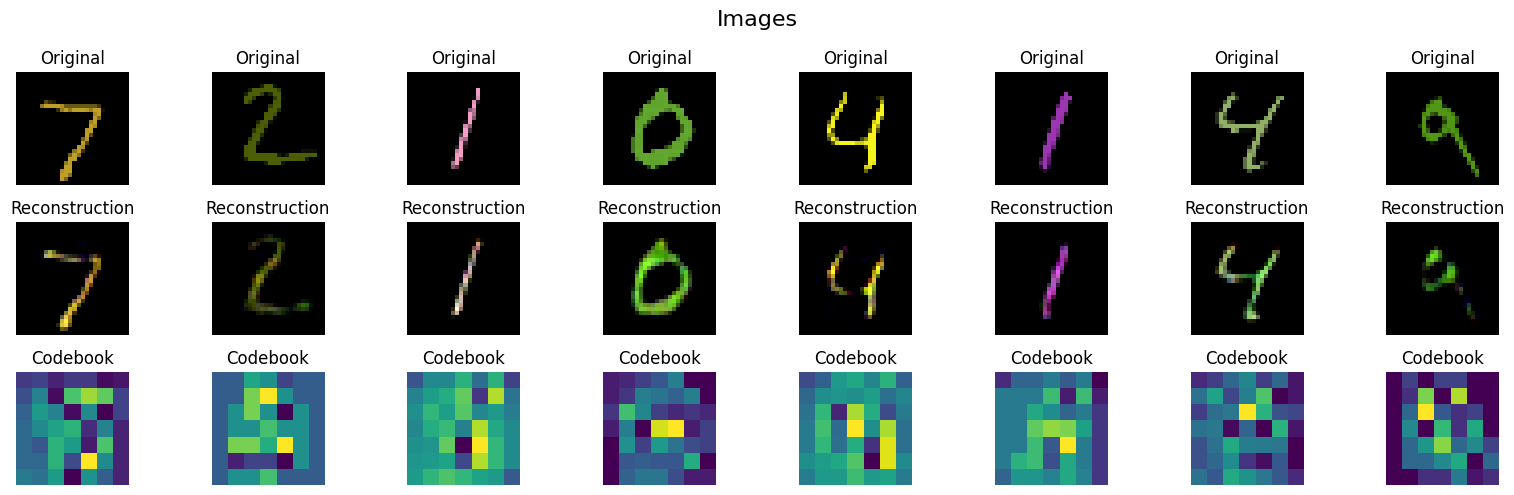


 To display the codeBook output, set num_channel to 1, along with the meanings for all 256 channels 

################################################################################################################################################################
 
 Train with Codebook dimension 16



100%|██████████| 375/375 [00:30<00:00, 12.47it/s]


Epoch 1/5, Train Loss: 0.3901, Validation Loss: 0.1416
Saved best model


100%|██████████| 375/375 [00:30<00:00, 12.27it/s]


Epoch 2/5, Train Loss: 0.1286, Validation Loss: 0.1129
Saved best model


100%|██████████| 375/375 [00:30<00:00, 12.49it/s]


Epoch 3/5, Train Loss: 0.1108, Validation Loss: 0.1042
Saved best model


100%|██████████| 375/375 [00:29<00:00, 12.54it/s]


Epoch 4/5, Train Loss: 0.1001, Validation Loss: 0.0985
Saved best model


100%|██████████| 375/375 [00:30<00:00, 12.47it/s]


Epoch 5/5, Train Loss: 0.1036, Validation Loss: 0.0977
Saved best model


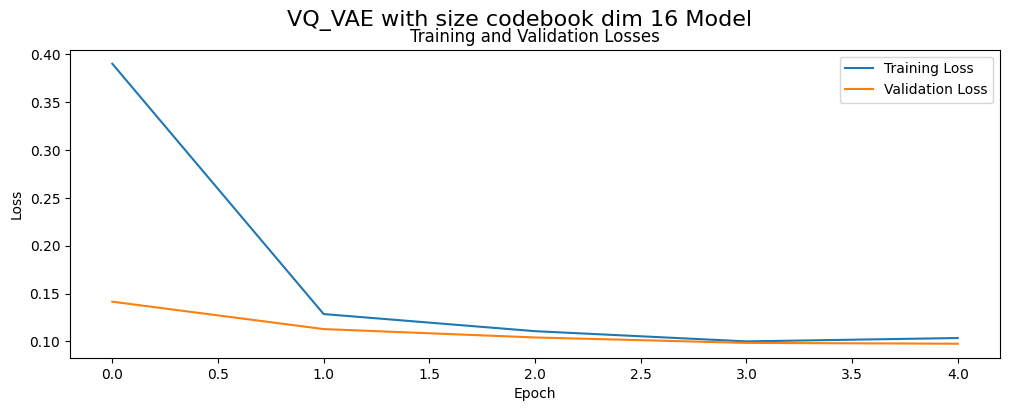

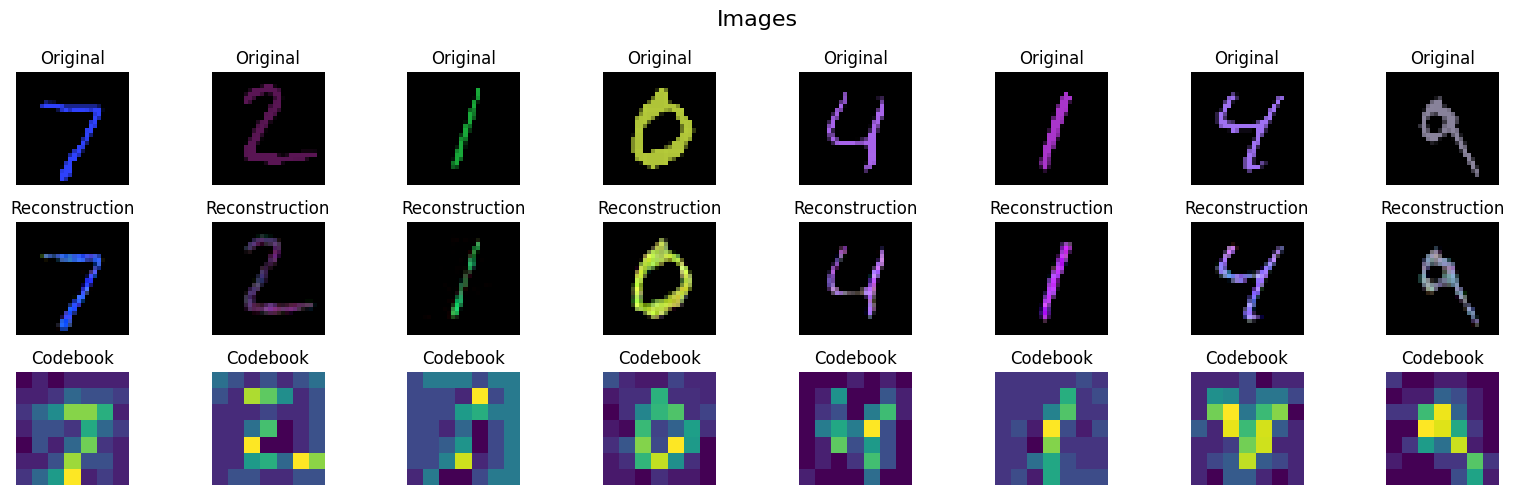


 To display the codeBook output, set num_channel to 1, along with the meanings for all 256 channels 

################################################################################################################################################################
 
 Train with Codebook dimension 32



100%|██████████| 375/375 [00:30<00:00, 12.39it/s]


Epoch 1/5, Train Loss: 0.5484, Validation Loss: 0.2838
Saved best model


100%|██████████| 375/375 [00:30<00:00, 12.46it/s]


Epoch 2/5, Train Loss: 0.2671, Validation Loss: 0.2630
Saved best model


100%|██████████| 375/375 [00:30<00:00, 12.44it/s]


Epoch 3/5, Train Loss: 0.2819, Validation Loss: 0.2939


100%|██████████| 375/375 [00:30<00:00, 12.25it/s]


Epoch 4/5, Train Loss: 0.2889, Validation Loss: 0.2799


100%|██████████| 375/375 [00:30<00:00, 12.19it/s]


Epoch 5/5, Train Loss: 0.2637, Validation Loss: 0.2685


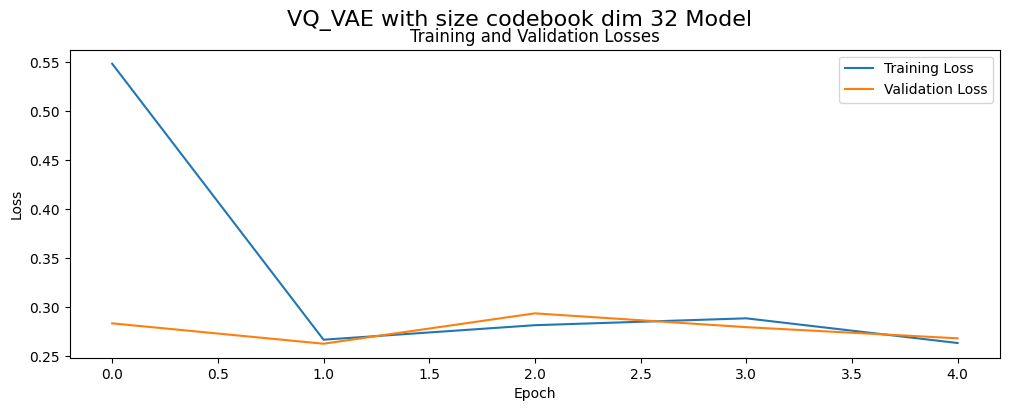

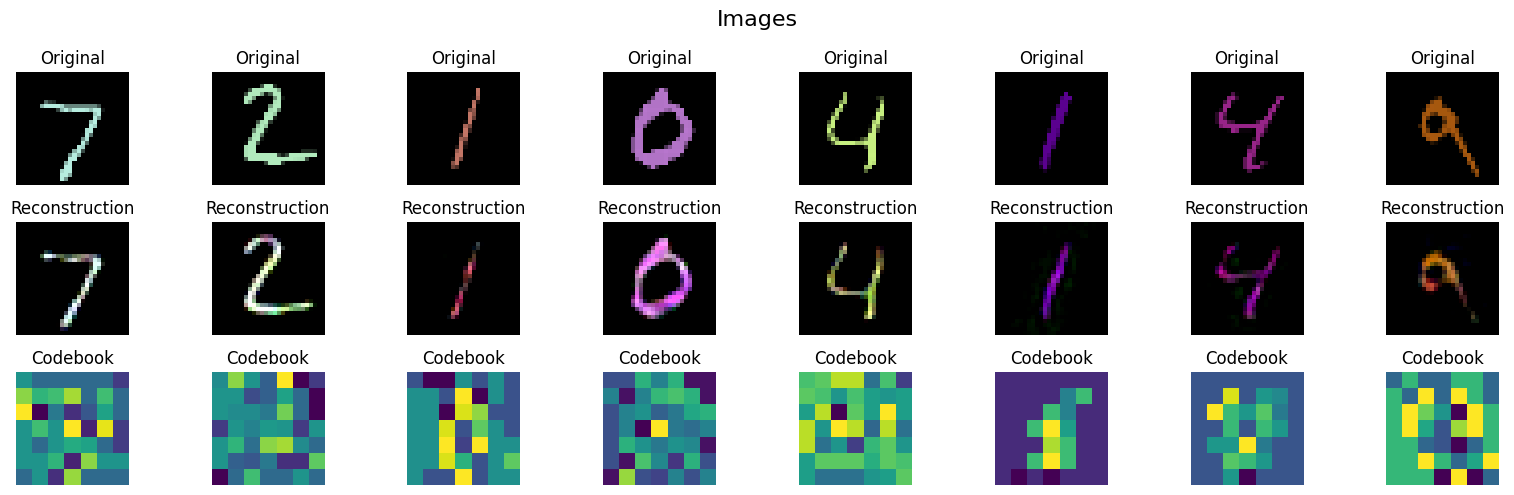


 To display the codeBook output, set num_channel to 1, along with the meanings for all 256 channels 



In [49]:
dim_codebook = [4,8,16,32]

for i in dim_codebook:
    print(40*'####')
    print(f" \n Train with Codebook dimension {i}\n")
    model=VQVAE(codebook_size=3,codebook_dim=i,in_channels=3,out_channels=3).to(device)
    optimizer= optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    my = model_train(model=model, Name = f'VQ_VAE with size codebook dim {i}', train_loader=train_loader, test_loader=test_loader, val_loader=val_loader,
                 optimizer=optimizer, criterion=criterion, num_epochs=5, device=device)
    my.train()
    my.Show_test_Image()

## Effect of Codebook Parameters in VQ-VAE

1. **Increased Dimension of Codebook Vectors:**
   - **Effect:** Higher capacity, better for capturing complex patterns.
   - **Considerations:** Increased memory requirements; consider computational resources.

2. **Increased Number of Codebook Vectors:**
   - **Effect:** Improved representation, captures finer details.
   - **Considerations:** Risk of overfitting; larger codebooks demand more resources.
